In [1]:
from dataClasses import *
from cachetools import cached
import copy
import time
import random
from typing import List, Set, Tuple, Dict
import pandas as pd
#import llist
import logging
import pprint
from vrpy import VehicleRoutingProblem
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from util import *
from validator.InstanceCO22 import InstanceCO22
import warnings
from collections import OrderedDict
from searchAlgorithms import randomLocalSearch, TreeSearch, EvolutionarySearch
warnings.filterwarnings("ignore", module="matplotlib\..*")
warnings.filterwarnings("ignore", module="vrpy\..*")


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.CRITICAL)
%reload_ext autoreload
%autoreload 2


## Initial solution & Depotsolution

In [2]:
def distance(loc1: InstanceCO22.Location, loc2: InstanceCO22.Location, ceil: bool = True) -> float:
    dist = math.sqrt((loc1.X - loc2.X)**2 + (loc1.Y - loc2.Y)**2)
    if ceil:
        return math.ceil(dist)
    else:
        return dist


def requestClosestHub(instance: InstanceCO22, request: InstanceCO22.Request) -> int:
    nHubs = len(instance.Hubs)
    hubs = instance.Locations[1:nHubs+1]
    minDist = math.inf
    minDistHubLocID = None
    for i, hub in enumerate(hubs):
        if request.ID in instance.Hubs[i].allowedRequests:
            hubDist = distance(
                instance.Locations[request.customerLocID-1], hub)
            if hubDist < minDist:
                minDist = hubDist
                minDistHubLocID = hub.ID
    return minDistHubLocID


def requestsClosestHub(instance: InstanceCO22) -> dict:
    # return dictionary of {'LOC_ID': ' NEAREST LOC_ID'}
    res = {}
    for req in instance.Requests:
        res[req.ID] = requestClosestHub(instance, req)
    return res


def requestsPerHub(instance: InstanceCO22) -> dict:
    closestHubPerRequest = requestsClosestHub(instance=instance)
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2, nHubs+2))
    res = {val: [] for val in hubLocIDs}
    for hubLocID in hubLocIDs:
        for reqID, closestHubLocID in closestHubPerRequest.items():
            if closestHubLocID is hubLocID:
                res[hubLocID].append(reqID)
    return res


def amountPerProduct(instance: InstanceCO22, requests: list) -> list:
    nProducts = len(instance.Products)
    res = [None]*nProducts
    for i in range(nProducts):
        res[i] = sum([req.amounts[i] for req in requests])
    return res


def filterRequests(instance: InstanceCO22, day: int = None, locationsID: int = None) -> list:
    res = instance.Requests.copy()
    if day != None:
        res = [_ for _ in res if _.desiredDay is day]
    if locationsID != None:
        res = [_ for _ in res if _.customerLocID in locationsID]
    return res


def addAllEdges(G: nx.DiGraph, checkWindowOverlap: bool = False) -> nx.DiGraph:
    for locID1, node1 in G.nodes(data=True):
        for locID2, node2 in G.nodes(data=True):
            if locID1 != locID2:
                if checkWindowOverlap and locID1 not in ["Source", "Sink"] and locID2 not in ["Source", "Sink"] and not windowOverlap(node1['periodIDs'], node2['periodIDs']):
                    continue
                dist = math.ceil(
                    math.sqrt(pow(node1['X']-node2['X'], 2) + pow(node1['Y']-node2['Y'], 2)))
                if locID1 == "Sink" or locID2 == "Source" or (locID1 == "Source" and locID2 == "Sink"):
                    continue
                else:
                    G.add_edge(locID1, locID2, time=dist, cost=dist)
    return G


def createNxHub(instance: InstanceCO22, hubLocID: int, requests: list) -> nx.DiGraph:
    G = nx.DiGraph()
    for req in requests:
        reqLoc = instance.Locations[req.customerLocID-1]
        G.add_node(req.ID, locID=reqLoc.ID, reqID=req.ID, X=reqLoc.X,
                   Y=reqLoc.Y, demand=sum(req.amounts), amounts=req.amounts)
    hubLoc = instance.Locations[hubLocID]
    G.add_node("Source", locID=hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G.add_node("Sink", locID=hubLocID, X=hubLoc.X, Y=hubLoc.Y)
    G = addAllEdges(G)
    return G


def solveHubVRP(instance: InstanceCO22, hubLocID: int, requests: list) -> dict:
    # create networkX
    G = createNxHub(instance, hubLocID, requests)
    G_dict = {i: v for i, v in G.nodes(data=True)}
    # print(G_dict.keys())
    prob = VehicleRoutingProblem(G, load_capacity=instance.VanCapacity)
    prob.duration = instance.VanMaxDistance
    prob.fixed_cost = instance.VanDayCost
    prob.solve()
    best_routes = prob.best_routes
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res = {
        'routes': {key: {'route': [G_dict[id] for id in best_routes[key]]} for key in best_routes.keys()},
        'demand': sum([sum(req.amounts) for req in requests]),
        'amounts': amountPerProduct(instance, requests)
    }
    return res


def createNxDepot(instance: InstanceCO22, dayRoutes: dict) -> nx.DiGraph:
    G = nx.DiGraph()
    # add hubs
    for (day, hubLocID), hubData in dayRoutes.items():
        G.add_node(f"{hubLocID}.1", locID=hubLocID, demand=0, amounts=0,
                   X=instance.Locations[hubLocID-1].X, Y=instance.Locations[hubLocID-1].Y)

    for (day, hubLocID), hubData in dayRoutes.items():
        i = 1
        nodeID = f"{hubLocID}.{i}"
        while nodeID in G.nodes and G.nodes[nodeID]['demand'] + hubData['demand'] > instance.TruckCapacity:
            i += 1
            nodeID = f"{hubLocID}.{i}"
        if nodeID not in G.nodes:
            G.add_node(nodeID, locID=hubLocID, demand=0, amounts=0,
                       X=instance.Locations[hubLocID-1].X, Y=instance.Locations[hubLocID-1].Y)

        G.nodes[nodeID]['amounts'] = list(
            np.array(G.nodes[nodeID]['amounts']) + np.array(hubData['amounts']))
        G.nodes[nodeID]['demand'] = G.nodes[nodeID]['demand']+hubData['demand']

    G.add_node("Source", locID=1,
               X=instance.Locations[0].X, Y=instance.Locations[0].Y)
    G.add_node("Sink", locID=1,
               X=instance.Locations[0].X, Y=instance.Locations[0].Y)

    G = addAllEdges(G)
    return G


def solveDepotVRP(instance: InstanceCO22, dayRoutes: dict) -> dict:
    # for solving per day
    G = createNxDepot(instance, dayRoutes)
    G_dict = {i: v for i, v in G.nodes(data=True)}
    print(G_dict.keys())

    prob = VehicleRoutingProblem(G, load_capacity=instance.TruckCapacity)
    prob.duration = instance.TruckMaxDistance
    prob.fixed_cost = instance.TruckDayCost
    prob.solve()
    best_routes = prob.best_routes
    # print(best_routes)
    #best_routes = {id:listReplace(best_routes[id], ["Source","Sink"], hubLocID) for id in best_routes.keys()}
    res = {key: [G_dict[id] for id in best_routes[key]]
           for key in best_routes.keys()}
    # print(res)
    return res


@cached(
    cache={},
    key=lambda a: a.CACHE_ID
)
def solveHub(instance: InstanceCO22) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubLocIDs = list(range(2, nHubs+2))
    hubClusters = requestsPerHub(instance)
    hubRoutes = {}
    for day in range(1, nDays+1):  # hub routing
        dayRoutes = {}
        for hubLocID in hubLocIDs:
            hubCluster = hubClusters[hubLocID]
            #requestsToServe = filterRequests(instance, day, hubCluster)
            requestsToServe = [
                _ for _ in instance.Requests if _.ID in hubCluster and _.desiredDay is day]
            #print(hubCluster, [_.ID for _ in requestsToServe])   #
            if(len(requestsToServe) > 0):
                dayHubRoutes = solveHubVRP(instance, hubLocID, requestsToServe)
                dayRoutes[hubLocID] = dayHubRoutes
        hubRoutes[day] = dayRoutes
    return hubRoutes

def parseToDayHubroutes(res):
    i = 0
    hubRoutesObject = HubRoutes()
    # take dictionary with structure as hubRoutes datamodel
    for day, dayData in res.items():
        dayHubRoutesObject = DayHubRoutes()
        for hubLocID, hubData in dayData.items():
            for routeID, routeData in hubData['routes'].items():
                route = HubRoute(i, hubLocID)
                for node in routeData['route'][1:-1]:  # ignore source and sink
                    nodeObject = Node(
                        reqID=node['reqID'], locID=node['locID'], amounts=node['amounts'], X=node['X'], Y=node['Y'])
                    route.addNode(nodeObject)
                dayHubRoutesObject.addRoute(route)
        hubRoutesObject.addDayHubRoutes(
            day=day, dayHubRoutes=dayHubRoutesObject)
    return hubRoutesObject


In [3]:
def extractDays(hubRoutes, days: list) -> dict:
    res = {}
    for day, dayRoutes in hubRoutes.items():
        if day in days:
            for hubLocID in dayRoutes:
                newID = (day, hubLocID)
                res[newID] = dayRoutes[hubLocID]
    return res

def solveDepot(instance: InstanceCO22, hubRoutes, useDMin = True) -> dict:
    nDays = instance.Days
    nHubs = len(instance.Hubs)
    hubRoutesDict = hubRoutes.toDict(instance)

    depotRoutes = {}
    
    if useDMin:
        dmin = min([_.daysFresh for _ in instance.Products])
    else: 
        dmin = 1

    for i in range(0, math.ceil(nDays/dmin)):
        periodBegin = dmin*i+1
        periodEnd = dmin*(i+1)+1
        print(i, periodBegin, periodEnd)
        period = list(range(periodBegin, periodEnd))
        periodRoutes = extractDays(hubRoutesDict, period)
        if len(periodRoutes) > 0:  # depot routing
            res = solveDepotVRP(instance, periodRoutes)
            depotRoutes[periodBegin] = res
        else:
            depotRoutes[periodBegin] = {}

    return {'hubRoutes': hubRoutesDict, 'depotRoutes': depotRoutes}

def solutionToStr(instance: InstanceCO22, res: dict):
    resultString = "DATASET = CO2022_11 \n \n"

    for day in range(1, instance.Days+1):
        resultString += f"DAY = {day} \n"

        truckString = ""
        if day in res['depotRoutes'].keys():
            nTrucks = len(res['depotRoutes'][day])
            for routeID, truckRoute in res['depotRoutes'][day].items():
                truckString += f"{routeID} "
                for i, hubData in enumerate(truckRoute[1:-1]):
                    amountPerProduct = hubData['amounts']
                    truckString += f"H{hubData['locID'] - 1} {','.join([str(_) for _ in amountPerProduct])} "
                truckString += "\n"
        else:
            nTrucks = 0

        resultString += f"NUMBER_OF_TRUCKS = {nTrucks} \n"
        resultString += truckString

        nVans = 0
        i = 0
        vanString = ""
        for hubLocID in res['hubRoutes'][day].keys():
            for _, route in res['hubRoutes'][day][hubLocID]['routes'].items():
                i += 1
                reqIds = [_['reqID'] for _ in route['route'][1:-1]]
                vanString += f"{i} H{hubLocID-1} {' '.join([str(_) for _ in reqIds])} \n"
            nVans += len(res['hubRoutes'][day][hubLocID]['routes'])
        resultString += f"NUMBER_OF_VANS = {nVans} \n"
        resultString += vanString + "\n"
    return resultString


## Testing evo search

In [37]:
def earlyStopper(costs):
    if len(costs) > 20:
        return costs[-1] == costs[-20] 
    return False

i = 21
instance = loadInstance(i)
initialState = parseToDayHubroutes(solveHub(instance))
searcher = EvolutionarySearch(instance = instance, initialState = initialState, generationSize=50, candidateSize=300, nGenerations=400)
bestState, bestStateCost = searcher.run(parallel=False)
res = solveDepot(instance, bestState)
solutionStr = solutionToStr(instance, res)
with open(f"./solutions/evolutionarysearch/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

Generation 1 - Size: 50 bestCost: 91160.0 elapsed: 2.39
Generation 2 - Size: 50 bestCost: 86160.0 elapsed: 1.81
Generation 3 - Size: 50 bestCost: 81160.0 elapsed: 1.45
Generation 4 - Size: 50 bestCost: 76160.0 elapsed: 1.13
Generation 5 - Size: 50 bestCost: 75890.0 elapsed: 1.10
Generation 6 - Size: 50 bestCost: 71060.0 elapsed: 1.09
Generation 7 - Size: 50 bestCost: 70660.0 elapsed: 2.26
Generation 8 - Size: 50 bestCost: 65890.0 elapsed: 1.73
Generation 9 - Size: 50 bestCost: 61060.0 elapsed: 1.08
Generation 10 - Size: 50 bestCost: 60870.0 elapsed: 1.46
Generation 11 - Size: 50 bestCost: 56060.0 elapsed: 1.53
Generation 12 - Size: 50 bestCost: 55910.0 elapsed: 1.11
Generation 13 - Size: 50 bestCost: 55660.0 elapsed: 1.51
Generation 14 - Size: 50 bestCost: 55510.0 elapsed: 1.59
Generation 15 - Size: 50 bestCost: 55210.0 elapsed: 1.10
Generation 16 - Size: 50 bestCost: 55210.0 elapsed: 1.87
Generation 17 - Size: 50 bestCost: 54870.0 elapsed: 1.08
Generation 18 - Size: 50 bestCost: 54660

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


Generation 401 - Size: 50 bestCost: 47560.0 elapsed: 0.91
Finished in 498.73 resulting in cost of: 96160.0 -> 47560.0
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


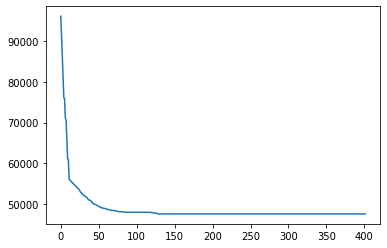

In [50]:
plt.plot(searcher.costs)

In [8]:
bestStateCost

131940.0

In [9]:
res = solveDepot(instance, bestState)
solutionStr = solutionToStr(instance, res)
with open(f"./solutions/treesearch/solution{i}.txt", 'w') as file:
    file.write(solutionStr)

INFO:vrpy.vrp:new upper bound : max num stops = 12
INFO:vrpy.vrp:Clarke & Wright solution found with value 2195 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2212 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2195.0


0 1 5
dict_keys(['10.1', '20.1', '15.1', '8.1', '19.1', '21.1', '6.1', '4.1', '13.1', '7.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 1, 2195.0
INFO:vrpy.vrp:iteration 2, 2195.0
INFO:vrpy.vrp:iteration 3, 2195.0
INFO:vrpy.vrp:iteration 4, 2195.0
INFO:vrpy.vrp:iteration 5, 2195.0
INFO:vrpy.vrp:iteration 6, 2195.0
INFO:vrpy.vrp:iteration 7, 2195.0
INFO:vrpy.vrp:iteration 8, 2195.0
INFO:vrpy.vrp:iteration 9, 2195.0
INFO:vrpy.vrp:iteration 10, 2195.0
INFO:vrpy.vrp:iteration 11, 2195.0
INFO:vrpy.vrp:iteration 12, 2195.0
INFO:vrpy.vrp:iteration 13, 2195.0
INFO:vrpy.vrp:iteration 14, 2195.0
INFO:vrpy.vrp:iteration 15, 2195.0
INFO:vrpy.vrp:iteration 16, 2195.0
INFO:vrpy.vrp:iteration 17, 2195.0
INFO:vrpy.vrp:iteration 18, 2195.0
INFO:vrpy.vrp:iteration 19, 2195.0
INFO:vrpy.vrp:iteration 20, 2195.0
INFO:vrpy.vrp:iteration 21, 2195.0
INFO:vrpy.vrp:iteration 22, 2192.0
INFO:vrpy.vrp:iteration 23, 2192.0
INFO:vrpy.vrp:iteration 24, 2192.0
INFO:vrpy.master_solve_pulp:total cost = 2192.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 2192 and 1 vehi

1 5 9
dict_keys(['19.1', '20.1', '6.1', '12.1', '15.1', '8.1', '10.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 2, 2192.0
INFO:vrpy.vrp:iteration 3, 2192.0
INFO:vrpy.vrp:iteration 4, 2192.0
INFO:vrpy.vrp:iteration 5, 2192.0
INFO:vrpy.vrp:iteration 6, 2192.0
INFO:vrpy.vrp:iteration 7, 2192.0
INFO:vrpy.vrp:iteration 8, 2192.0
INFO:vrpy.vrp:iteration 9, 2192.0
INFO:vrpy.vrp:iteration 10, 2192.0
INFO:vrpy.vrp:iteration 11, 2192.0
INFO:vrpy.vrp:iteration 12, 2192.0
INFO:vrpy.vrp:iteration 13, 2192.0
INFO:vrpy.vrp:iteration 14, 2192.0
INFO:vrpy.vrp:iteration 15, 2188.0
INFO:vrpy.master_solve_pulp:total cost = 2188.0
INFO:vrpy.vrp:new upper bound : max num stops = 9
INFO:vrpy.vrp:Clarke & Wright solution found with value 2216 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2222 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2216.0
INFO:vrpy.vrp:iteration 1, 2216.0
INFO:vrpy.vrp:iteration 2, 2216.0
INFO:vrpy.vrp:iteration 3, 2216.0
INFO:vrpy.vrp:iteration 4, 2216.0


2 9 13
dict_keys(['2.1', '18.1', '13.1', '7.1', '4.1', '20.1', '21.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 5, 2216.0
INFO:vrpy.vrp:iteration 6, 2216.0
INFO:vrpy.vrp:iteration 7, 2216.0
INFO:vrpy.vrp:iteration 8, 2216.0
INFO:vrpy.vrp:iteration 9, 2216.0
INFO:vrpy.vrp:iteration 10, 2216.0
INFO:vrpy.vrp:iteration 11, 2216.0
INFO:vrpy.vrp:iteration 12, 2216.0
INFO:vrpy.vrp:iteration 13, 2216.0
INFO:vrpy.vrp:iteration 14, 2216.0
INFO:vrpy.vrp:iteration 15, 2216.0
INFO:vrpy.vrp:iteration 16, 2216.0
INFO:vrpy.vrp:iteration 17, 2216.0
INFO:vrpy.master_solve_pulp:total cost = 2216.0
INFO:vrpy.vrp:new upper bound : max num stops = 8
INFO:vrpy.vrp:Clarke & Wright solution found with value 2206 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2217 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2206.0
INFO:vrpy.vrp:iteration 1, 2206.0
INFO:vrpy.vrp:iteration 2, 2206.0
INFO:vrpy.vrp:iteration 3, 2206.0
INFO:vrpy.vrp:iteration 4, 2206.0


3 13 17
dict_keys(['12.1', '15.1', '11.1', '6.1', '18.1', '19.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 5, 2206.0
INFO:vrpy.vrp:iteration 6, 2206.0
INFO:vrpy.vrp:iteration 7, 2206.0
INFO:vrpy.vrp:iteration 8, 2206.0
INFO:vrpy.vrp:iteration 9, 2206.0
INFO:vrpy.master_solve_pulp:total cost = 2206.0
INFO:vrpy.vrp:new upper bound : max num stops = 10
INFO:vrpy.vrp:Clarke & Wright solution found with value 2189 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2203 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2189.0


4 17 21
dict_keys(['18.1', '10.1', '7.1', '20.1', '4.1', '13.1', '8.1', '2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 1, 2189.0
INFO:vrpy.vrp:iteration 2, 2189.0
INFO:vrpy.vrp:iteration 3, 2189.0
INFO:vrpy.vrp:iteration 4, 2189.0
INFO:vrpy.vrp:iteration 5, 2189.0
INFO:vrpy.vrp:iteration 6, 2189.0
INFO:vrpy.vrp:iteration 7, 2189.0
INFO:vrpy.vrp:iteration 8, 2189.0
INFO:vrpy.vrp:iteration 9, 2189.0
INFO:vrpy.vrp:iteration 10, 2189.0
INFO:vrpy.vrp:iteration 11, 2189.0
INFO:vrpy.vrp:iteration 12, 2189.0
INFO:vrpy.vrp:iteration 13, 2189.0
INFO:vrpy.vrp:iteration 14, 2189.0
INFO:vrpy.vrp:iteration 15, 2189.0
INFO:vrpy.vrp:iteration 16, 2189.0
INFO:vrpy.vrp:iteration 17, 2189.0
INFO:vrpy.vrp:iteration 18, 2189.0
INFO:vrpy.vrp:iteration 19, 2189.0
INFO:vrpy.vrp:iteration 20, 2189.0
INFO:vrpy.vrp:iteration 21, 2189.0
INFO:vrpy.vrp:iteration 22, 2189.0
INFO:vrpy.vrp:iteration 23, 2189.0
INFO:vrpy.vrp:iteration 24, 2189.0
INFO:vrpy.vrp:iteration 25, 2189.0
INFO:vrpy.vrp:iteration 26, 2189.0
INFO:vrpy.vrp:iteration 27, 2188.0
INFO:vrpy.master_solve_pulp:total cost = 2188.0


In [16]:
import joblib
joblib.cpu_count()

4

In [48]:
for j ,bestState in enumerate(searcher.generations[-1]):
    res = solveDepot(instance, bestState)
    solutionStr = solutionToStr(instance, res)
    with open(f"./solutions/treesearch/solution{i}_{j}.txt", 'w') as file:
        file.write(solutionStr)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


1 5 9
dict_keys(['2.1', 'Source', 'Sink'])
2 9 13
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


3 13 17
dict_keys(['2.1', 'Source', 'Sink'])
4 17 21
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles


0 1 5
dict_keys(['2.1', 'Source', 'Sink'])
1 5 9
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0


2 9 13
dict_keys(['2.1', 'Source', 'Sink'])
3 13 17
dict_keys(['2.1', 'Source', 'Sink'])


INFO:vrpy.master_solve_pulp:total cost = 2088.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:Clarke & Wright solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:Greedy solution found with value 2088 and 1 vehicles
INFO:vrpy.vrp:iteration 0, 2088.0
INFO:vrpy.master_solve_pulp:total cost = 2088.0


4 17 21
dict_keys(['2.1', 'Source', 'Sink'])
